Nous allons essayer de reconnaitre des nombres écrit à la main grace à un réseau de neuronne.

In [1]:
import tensorflow as tf
import matplotlib.pyplot as plt
import numpy as np
import pickle

In [2]:
(X_train, Y_train), (X_test, Y_test) = tf.keras.datasets.mnist.load_data()

y_train = np.zeros((len(Y_train), 10))
y_train[np.arange(len(Y_train)), Y_train] = 1 # to categorical
y_test = np.zeros((len(Y_test), 10))
y_test[np.arange(len(Y_test)), Y_test] = 1 # to categorical 
# cela permet de transformer la sortie en une liste [0, 0, 0, 0, 0, 0, 0, 0 ,0, 0, 0] 
# avec un 1 à l'indice n
# par exemple si le nombre cherché est 2 : [0, 0, 1, 0, 0, 0, 0, 0 ,0, 0, 0] 

x_train = X_train.reshape(-1, 28*28)/255 # 28*28 = 784
x_test = X_test.reshape(-1, 28*28)/255

# POO

## Activation

In [3]:
"""
Fonction activation Sigmoid
"""
def sigmoid(x, derive=False):
    """
    Fonction Sigmoid
    """
    if derive:
        return np.exp(-x) / ((1+np.exp(-x)) ** 2)
    return 1 / (1 + np.exp(-x))

"""
Fonction activation Softmax
https://levelup.gitconnected.com/killer-combo-softmax-and-cross-entropy-5907442f60ba
"""
def softmax(y, derivative=False):
    result = []
    for x in y:
        exps = np.exp(x - x.max()) # permet d'éviter une exponentielle trop grande
        if derivative:
            result.append(exps / np.sum(exps, axis=0) * (1 - exps / np.sum(exps, axis=0)))
        else:
            result.append(exps / np.sum(exps, axis=0))
    return np.array(result)

## Layers

In [17]:
class Layer:
    def __init__(self, input_n=2, output_n=2, lr=0.1, activation=None):
        """
        Crée un layer de n neuronne connecté aux layer de input neuronnes
        """
        # input_n le nombre d'entrée du neuronne
        # output_n le nombre de neuronne de sortie
        self.weight = np.random.randn(input_n, output_n)
        self.dw_moment = np.zeros((input_n, output_n))
        self.input_n = input_n
        self.output_n = output_n
        self.lr = lr # learning rate

        # the name of the layer is 1
        # next one is 2 and previous 0
        self.predicted_output_ = 0
        self.predicted_output  = 0
        self.input_data = 0

        # Fonction d'activation
        self.activation = activation if activation != None else lineaire

    def calculate(self, input_data):
        """
        Calcule la sortie
        """
        self.input_data = input_data
        # self.input_data = np.concatenate((input_data, np.ones((len(input_data), 1))), axis=1)
        y1 = np.dot(self.input_data, self.weight)
        z1 = self.activation(y1)
        self.predicted_output_ = y1
        self.predicted_output = z1
        return y1, z1

    def learn(self, e_2):
        """
        Permet de mettre à jour les weigths
        """
        e1 = e_2 / self.output_n * self.activation(self.predicted_output_, True)
        # e_0 is for the next layer
        # e_0 = np.dot(e1, self.weight.T)
        e_0 = np.dot(e1, self.weight.T)
        dw1 = np.dot(e1.T, self.input_data)
        self.weight -= dw1.T * self.lr
        return e_0
    
    def learn_moment(self, e_2, gamma=0.5):
        """
        Permet de mettre à jour les weigths
        """
        e1 = e_2 / self.output_n * self.activation(self.predicted_output_, True)
        # e_0 is for the next layer
        # e_0 = np.dot(e1, self.weight.T)
        e_0 = np.dot(e1, self.weight.T)
        dw1 = np.dot(e1.T, self.input_data)
        """
        La différence se trouve ici
        """
        self.dw_moment = gamma * self.dw_moment + dw1.T * self.lr
        self.weight -= self.dw_moment
        return e_0

## Loss function

In [5]:
"""
Mean Square Error function
Je l'utilise mais il serait mieux d'utiliser cross entropy normalement
"""
def mse(predicted_output, target_output, derivate=False):
    if derivate:
        return (predicted_output - target_output) *2 
    return ((predicted_output - target_output) ** 2).mean()

## Model

In [6]:
class Model:

    def __init__(self, layers=[], loss_function=None):
        self.layers = layers
        self.loss = []
        self.lr = 0.1
        self.loss_function = loss_function  

    def predict(self, input_data):
        predicted_output = input_data  # y_ is predicted data
        for layer in self.layers:
            predicted_output_, predicted_output = layer.calculate(predicted_output) # output
        return predicted_output

    def predict_loss(self, input_data, target_output):  # target_output is expected data
        predicted_output = self.predict(input_data)  # y_ is predicted data
        loss = self.loss_function(predicted_output, target_output)
        return predicted_output, loss
    
    
    def compute_accuracy(self, x_val, y_val):
        predictions = []
        for x, y in zip(x_val, y_val):
            output = self.predict([x])
            pred = np.argmax(output[0])
            predictions.append(pred == np.argmax(y))
        return np.mean(predictions)

    def backpropagation(self, input_data, target_output, batch=None):
        n = len(input_data)
        if batch is None:
            batch = n
        step = n//batch
        losses = []
        for i in range(step):
            b_input_data = input_data[::step]
            b_target_output = target_output[::step]
            predicted_output, loss = self.predict_loss(b_input_data, b_target_output)
            d_loss = self.loss_function(predicted_output, b_target_output, True) # dérivé de loss dy_/dy
            # Entrainement des layers
            for i in range(len(self.layers)):
                d_loss = self.layers[-i - 1].learn(d_loss)
            losses.append(loss)
        loss = sum(losses)/len(losses)
        self.loss.append(loss)
        return loss

In [21]:
# Le model est de taille 784 -> 32 sigmoid -> 16 sigmoid -> 10 softmax
lr = 0.001
np.random.seed(2) # permet de rendre le programme reproductible
model = Model([
    Layer(784, 32, lr, sigmoid),
    Layer(32, 16, lr, sigmoid),
    Layer(16, 10, lr, softmax),
], mse)

In [22]:
# Entrainement lr = 0.001
loss_sans_moment = []
acc_sans_moment = []
for i in range(50):
    loss = model.backpropagation(x_train, y_train)
    acc = model.compute_accuracy(x_test, y_test)
    loss_sans_moment.append(loss)
    acc_sans_moment.append(acc)
    print(f"Epoch : {i} loss : {loss}, acc : {round(acc*100, 2)} %")
# Sur un des test précédement réalisé, après 3000 entrainement, on obtient 70% d'accuracy

Epoch : 0 loss : 0.151419233487184, acc : 11.51 %
Epoch : 1 loss : 0.1157290798817189, acc : 12.01 %
Epoch : 2 loss : 0.1081752170670607, acc : 10.0 %
Epoch : 3 loss : 0.10180303771541105, acc : 10.32 %
Epoch : 4 loss : 0.09722655973188295, acc : 13.24 %
Epoch : 5 loss : 0.09452930048303006, acc : 13.27 %
Epoch : 6 loss : 0.09420079021127374, acc : 13.34 %
Epoch : 7 loss : 0.09388583492810146, acc : 13.67 %
Epoch : 8 loss : 0.09358154596426761, acc : 14.03 %
Epoch : 9 loss : 0.09328117087748627, acc : 14.24 %
Epoch : 10 loss : 0.09298778701802908, acc : 14.84 %
Epoch : 11 loss : 0.0926988624362722, acc : 15.11 %
Epoch : 12 loss : 0.0924154419825512, acc : 15.55 %
Epoch : 13 loss : 0.09213662672953978, acc : 15.87 %
Epoch : 14 loss : 0.09186268533033595, acc : 16.3 %
Epoch : 15 loss : 0.09159327645562816, acc : 16.76 %
Epoch : 16 loss : 0.09132842925791806, acc : 17.22 %
Epoch : 17 loss : 0.09106799753211056, acc : 17.92 %
Epoch : 18 loss : 0.09081196154177407, acc : 18.27 %
Epoch : 19 

In [29]:
def backpropagation(model, input_data, target_output, gamma):
    n = len(input_data)
    losses = []
    predicted_output, loss = model.predict_loss(input_data, target_output)
    d_loss = model.loss_function(predicted_output, target_output, True) # dérivé de loss dy_/dy
    # Entrainement des layers
    for i in range(len(model.layers)):
        d_loss = model.layers[-i - 1].learn_moment(d_loss, gamma)
    losses.append(loss)
    loss = sum(losses)/len(losses)
    model.loss.append(loss)
    return loss

In [36]:
lr = 0.001
np.random.seed(2) # permet de rendre le programme reproductible
model = Model([
    Layer(784, 32, lr, sigmoid),
    Layer(32, 16, lr, sigmoid),
    Layer(16, 10, lr, softmax),
], mse)

gamma = 0.5
loss_avec_moment = []
acc_avec_moment = []
# Entrainement lr = 0.001
for i in range(50):
    loss = backpropagation(model, x_train, y_train, gamma)
    acc = model.compute_accuracy(x_test, y_test)
    loss_avec_moment.append(loss)
    acc_avec_moment.append(acc)
    print(f"Epoch : {i} loss : {loss}, acc : {round(acc*100, 2)} %")
# Sur un des test précédement réalisé, après 3000 entrainement, on obtient 70% d'accuracy

Epoch : 0 loss : 0.151419233487184, acc : 11.51 %
Epoch : 1 loss : 0.1157290798817189, acc : 11.72 %
Epoch : 2 loss : 0.11249339389212779, acc : 12.25 %
Epoch : 3 loss : 0.11062490654378145, acc : 8.8 %
Epoch : 4 loss : 0.11917333920504058, acc : 9.94 %
Epoch : 5 loss : 0.10149090638063976, acc : 12.71 %
Epoch : 6 loss : 0.09873874691161738, acc : 13.75 %
Epoch : 7 loss : 0.09952820723479446, acc : 12.49 %
Epoch : 8 loss : 0.09606871856240881, acc : 12.24 %
Epoch : 9 loss : 0.09493010901571333, acc : 16.81 %
Epoch : 10 loss : 0.09223952969779603, acc : 17.93 %
Epoch : 11 loss : 0.09094869158899667, acc : 17.48 %
Epoch : 12 loss : 0.09037286521987485, acc : 19.59 %
Epoch : 13 loss : 0.08955205674455574, acc : 20.73 %
Epoch : 14 loss : 0.08902868230069685, acc : 21.22 %
Epoch : 15 loss : 0.08860403943172397, acc : 22.11 %
Epoch : 16 loss : 0.08818231971219476, acc : 22.56 %
Epoch : 17 loss : 0.08777217803236351, acc : 23.16 %
Epoch : 18 loss : 0.08738391831223757, acc : 23.84 %
Epoch : 1

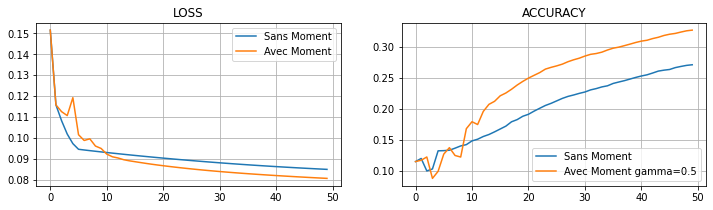

In [38]:
fig, axs = plt.subplots(1, 2, figsize=(12, 3))

ax0 = axs[0]
ax0.plot(loss_sans_moment, label="Sans Moment")
ax0.plot(loss_avec_moment, label="Avec Moment")
ax0.set_title("LOSS")
ax0.grid()
ax0.legend()

ax1 = axs[1]
ax1.plot(acc_sans_moment, label="Sans Moment")
ax1.plot(acc_avec_moment, label="Avec Moment gamma=0.5")
ax1.set_title("ACCURACY")
ax1.grid()
ax1.legend()

In [12]:
# sauvegarde du model
pickle.dump( model, open( "demo.p", "wb" ) )

# Test sur le model

In [13]:
model = pickle.load( open( "demo.p", "rb" ) )

In [14]:
# L'accuracy n'est pas le meme selon les nombres
for i in range(10):
    indexer = (Y_test == i)
    acc = model.compute_accuracy(x_test[indexer], y_test[indexer])
    print(f"For {i} accuracy is {round(acc * 100, 2)}")

For 0 accuracy is 28.06
For 1 accuracy is 80.0
For 2 accuracy is 6.49
For 3 accuracy is 7.52
For 4 accuracy is 14.05
For 5 accuracy is 6.95
For 6 accuracy is 47.08
For 7 accuracy is 39.2
For 8 accuracy is 9.34
For 9 accuracy is 23.79


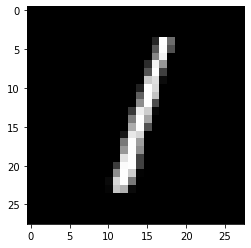

In [24]:
plt.imshow(X_test[2], cmap="gray")
plt.show()

In [25]:
model.predict([x_test[2]]).argmax()

1

In [27]:
model.predict([x_test[1]])

array([[0.11776384, 0.03745747, 0.13988358, 0.17766919, 0.13496387,
        0.01081449, 0.28744254, 0.04125383, 0.02985277, 0.02289842]])